In [22]:
%%capture
!pip install zarr
!pip install s3fs
!pip install matplotlib
!pip install shapely
!pip install numcodecs


In [23]:
import matplotlib.pylab as plt
import numpy as np
import s3fs
import zarr
from numcodecs import LZMA, Blosc


We believe that AI should be a tool we can all just use now. And that it should be just 
easy-as to go grab some data and experiment/learn. Geophysical data doesn't always 
fit the bill, so we made this notebook. Enjoy!

The Ichthys3D is for the "2020 FORCE Machine Learning Contest"

https://xeek.ai/challenges/force-seismic/rules

This data for Ichthys field data is provided Geoscience Australia under CC-BY 4.0.

The "Ichthys 3D seismic for fault competition" segy data has been converted to ZArr, 
this notebook provides an example. 

In [61]:
# Location of the segy data in "ZArr format"
segy_path='s3://zarr-depot/seismic/Ichthys3D/Ichthys 3D seismic for fault competition'

In [62]:
# complicated stuff to access the data
client = s3fs.S3FileSystem(anon=True)
store = s3fs.S3Map(
    root=segy_path,
    s3=client, 
    check=False)
cache = zarr.LRUStoreCache(store, max_size=2**28)
# contains the seqy data for Ichthys3D
segy_data = zarr.open_group(store=cache, mode='r')

In [63]:
# contents:
[i for i in segy_data.keys()]

['coordinates',
 'indptr',
 'inline',
 'inlines',
 'map_inline_ends',
 'map_latitude',
 'map_longitude',
 'map_xline_ends',
 'trace_inlines',
 'trace_xlines',
 'xline',
 'xlines']

In [64]:
print ("inline range : ", segy_data['inlines'][:].min(), segy_data['inlines'][:].max())
print ("xline range : ", segy_data['xlines'][:].min(), segy_data['xlines'][:].max())

inline range :  1001 3400
xline range :  2040 3040


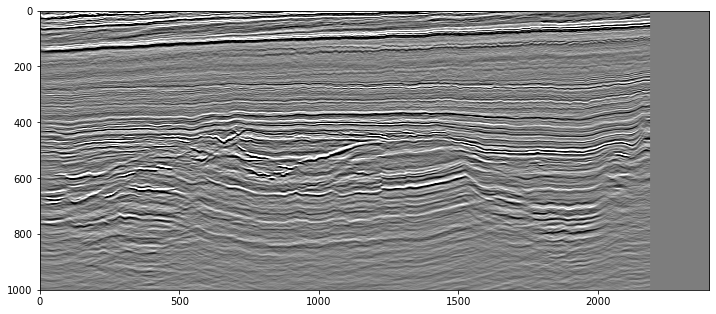

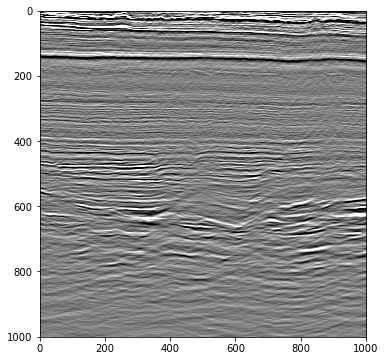

In [69]:
def clip(img):
    """Standardize contrast"""
    img = img - np.mean(img)
    return img/np.std(img)

# These are 8-bit unsigned ints
plt.figure(figsize=(12,6))
plt.imshow(clip(segy_data['xline'][...,2600].T), cmap='gray', vmin=-2, vmax=2)
plt.show()

# slice data in the xline/inline direction
# Dead traces padded with 0's
plt.figure(figsize=(12,6))
plt.imshow(clip(segy_data['inline'][...,1010].T), cmap='gray', vmin=-2, vmax=2)
plt.show()

In [66]:
%%timeit
x = segy_data['xline'][...,2400:2420]

1.39 s ± 33.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [67]:
from time import time
st = time()
x = segy_data['xline'][...,2300:2320]
print ("Elapsed time : ", time() - st)

Elapsed time :  4.50075888633728


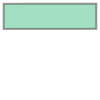

In [68]:
from shapely.geometry import Polygon
# lat/lon bounding the survey
lati, longi = segy_data['map_latitude'][:], segy_data['map_longitude'][:]
points = np.vstack((longi, lati)).T
Polygon(points)